<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Note:-I-recommend-viewing-the-results-first-(don't-toggle-on-the-code-yet),-and-then-the-code.-Keep-clicking-the-run-button-until-you-get-to-the-recommender-system-code-section,-and-follow-the-instructions-there." data-toc-modified-id="Note:-I-recommend-viewing-the-results-first-(don't-toggle-on-the-code-yet),-and-then-the-code.-Keep-clicking-the-run-button-until-you-get-to-the-recommender-system-code-section,-and-follow-the-instructions-there.-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Note: I recommend viewing the results first (don't toggle on the code yet), and then the code. Keep clicking the run button until you get to the recommender system code section, and follow the instructions there.</a></span></li><li><span><a href="#Recommender-system-model" data-toc-modified-id="Recommender-system-model-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Recommender system model</a></span></li><li><span><a href="#Unrelated-items-below-(PCA-analysis,-predicting-position-of-track-in-playlist)" data-toc-modified-id="Unrelated-items-below-(PCA-analysis,-predicting-position-of-track-in-playlist)-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Unrelated items below (PCA analysis, predicting position of track in playlist)</a></span></li><li><span><a href="#Models-for-predicting-position-of-track-in-playlist" data-toc-modified-id="Models-for-predicting-position-of-track-in-playlist-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Models for predicting position of track in playlist</a></span></li></ul></div>

In [30]:
import pandas as pd
import numpy as np
import random
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials
import json
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import seaborn as sns
from __future__ import print_function
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from IPython.display import Javascript
from IPython.display import HTML

## Note: I recommend viewing the results first (don't toggle on the code yet), and then the code. Keep clicking the run button until you get to the recommender system code section, and follow the instructions there.

In [31]:
HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

In [32]:
songs_df = pd.read_csv('initial_feature_data_songs999.csv')
del songs_df['Unnamed: 0']
songs_df.head()

,pid,pos,artist_name,track_uri,artist_uri,track_name,album_uri,duration_ms,album_name,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
0,0,0,Yiruma,spotify:track:7fnqltLx83HsYLQajzCYRk,spotify:artist:0fauHpmSHwodVYIjTqOGHz,River Flows In You,spotify:album:0vIR7YccgfLA1f5wcXZa4Z,185013,River Flows In You,0.988,0.2070,0.0880,-21.487,144.547,0.1090,0.320,0.0512
1,0,1,Frédéric Chopin,spotify:track:3w8507pR0Ncycrol0ZJOwP,spotify:artist:7y97mc3bZRFXzT2szRM4L4,Ballade No. 4 in F minor Op. 52,spotify:album:2ML75R6Z1LEFgPNZS0Ce3D,676000,The Best of Chopin,0.993,0.1050,0.1030,-24.507,70.014,0.0377,0.270,0.0439
2,0,2,Alexander Pitamic,spotify:track:59E6rPql7W8q2sodZpg1qQ,spotify:artist:4TuTJcUBhYyPoHYTSQzGAM,"Serenade für Streicher Nr. 13, G-Dur, KV 525: ...",spotify:album:3V8JHEeOhi7Z765C6v3Pqr,391000,"Wolfgang Amadeus Mozart: Sinfonie Nr. 29, A-Du...",0.952,0.0763,0.1000,-20.524,122.174,0.4100,0.544,0.0505
3,0,3,Johann Sebastian Bach,spotify:track:48BSXfxyLLxDIp934Is2A9,spotify:artist:5aIqB5nVVvmFsvSdExz408,"Cello Suite No. 1 in G Major, BWV 1007: I. Pre...",spotify:album:2cj4D33pmIvDCiDYWg80Nj,132120,"Bach, J.S.: 6 Suites for Solo Cello, Bwv 1007-...",0.990,0.2130,0.0859,-20.577,79.423,0.6170,0.341,0.0715
4,0,4,Hans Zimmer,spotify:track:4aW4Dpz3gpb619hBXDrFUa,spotify:artist:0YC192cP3KPCRWx8zr8MfZ,"Honor [Main Title Theme From ""The Pacific""]",spotify:album:0NH1WrtzRBlZS1VJX2XnXr,176587,The Pacific (Music From the HBO Miniseries),0.335,0.2760,0.1100,-14.830,68.619,0.0575,0.190,0.0346


In [33]:
songs_df.describe()

,pid,pos,duration_ms,acousticness,energy,liveness,loudness,tempo,valence,danceability,speechiness
count,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000,3175.000000
mean,20.778898,62.110866,232801.359370,0.224359,0.666765,0.197051,-7.328659,122.522027,0.496176,0.562059,0.079370
std,12.706229,54.751846,78722.583095,0.273712,0.218357,0.166337,3.780474,29.790286,0.250990,0.168482,0.080733
min,0.000000,0.000000,14213.000000,0.000002,0.007610,0.015700,-33.350000,0.000000,0.000000,0.000000,0.000000
25%,9.000000,19.000000,190302.500000,0.013150,0.529000,0.094950,-8.703500,99.865500,0.294000,0.446000,0.035000
50%,20.000000,46.000000,221623.000000,0.095800,0.697000,0.131000,-6.478000,120.033000,0.486000,0.573000,0.047600
75%,34.000000,92.000000,258940.000000,0.362500,0.843000,0.254000,-4.907000,141.927000,0.697500,0.686000,0.082550
max,44.000000,233.000000,941360.000000,0.993000,0.997000,0.994000,1.586000,219.297000,0.990000,0.967000,0.750000


Here, we make the decision not to scale the pid and pos columns, given that the ordering of the columns is important.

In [34]:
num_vars = songs_df.drop(['pid', 'pos', 'artist_name', 'track_uri', 'artist_uri', 'track_name', 'album_uri', 'album_name'], axis=1)

In [35]:
# Fit the scaler on the training data
scaler = StandardScaler().fit(num_vars)

# Scale both the test and training data. 
new_scaled_df = pd.DataFrame(scaler.transform(num_vars), columns = num_vars.columns)

In [36]:
from sklearn.cluster import KMeans
#Use random_state so the cluster assignment doesn't change
kmeans = KMeans(n_clusters=3, random_state=969)
kmeans.fit(new_scaled_df)
y_kmeans = kmeans.predict(new_scaled_df)
y_kmeans

array([2, 2, 2, ..., 0, 0, 0])

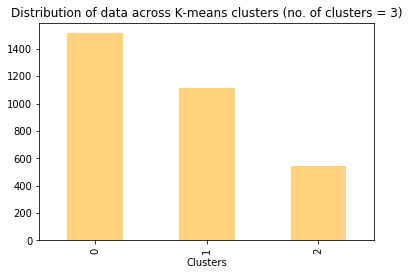

In [37]:
pd.value_counts(y_kmeans).plot(kind="bar", color="orange", alpha = 0.5)
plt.title("Distribution of data across K-means clusters (no. of clusters = 3)")
plt.xlabel("Clusters");

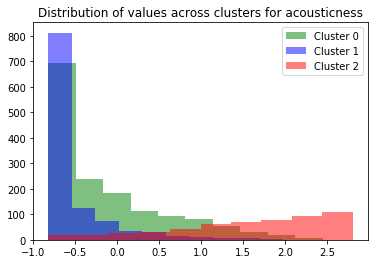

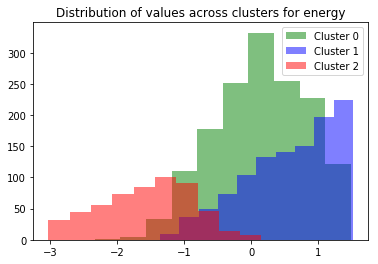

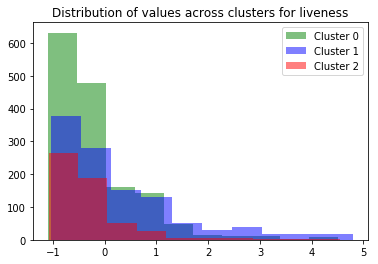

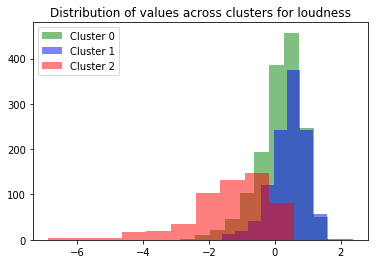

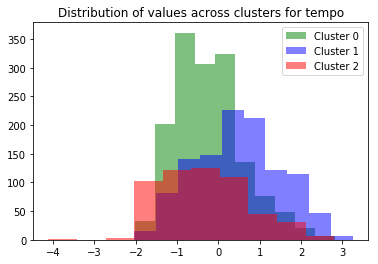

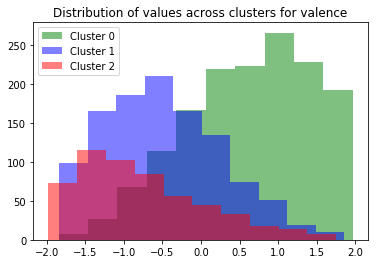

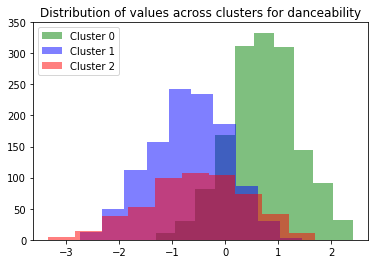

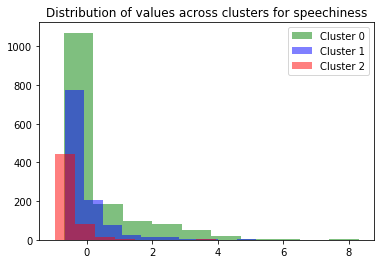

In [38]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']
for i in list_of_audio_features:
    plt.figure()
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 0, str(i)], color="green", alpha=0.5, label="Cluster 0")
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 1, str(i)], color="blue", alpha=0.5, label="Cluster 1")
    plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 2, str(i)], color="red", alpha=0.5, label="Cluster 2")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 3, str(i)], color="orange", alpha=0.5, label="Cluster 3")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 4, str(i)], color="pink", alpha=0.5, label="Cluster 4")
    #plt.hist(new_scaled_df.loc[pd.DataFrame(y_kmeans)[0] == 5, str(i)], color="brown", alpha=0.5, label="Cluster 5")
    plt.legend();
    plt.title("Distribution of values across clusters for " + str(i))

## Recommender system model

In [39]:
#Take a short quiz!

#TODO: Can give multiple songs!
print("Enter in your playlist - One song only please (for now)")
print("Note: Don't re-run this code cell, unless you want to start over")
print("If you're unsure what to pick, try entering 'River Flows In You' with no quotes")
input_orig_playlist = widgets.Textarea(
    placeholder='One song only please (for now)',
    description='Playlist:',
    disabled=False
)


#done_button = widgets.Button(
#    value=False,
#    description="Click me when you're done",
#    disabled=False,
#    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#    tooltip='Description',
#    icon='check'
#)

display(input_orig_playlist)
print("Once you're done entering in your song, run the next ipython cell (not this one!)")
#done_button.on_click(other_stuff) 
#if done_flag == "Done":

#def run_all(ev):
#    display(Javascript('IPython.notebook.execute_cells_below()'))

#done_button.on_click(run_all)

Enter in your playlist - One song only please (for now)
Note: Don't re-run this code cell, unless you want to start over
If you're unsure what to pick, try entering 'River Flows In You' with no quotes


Textarea(value='', description='Playlist:', placeholder='One song only please (for now)')

Once you're done entering in your song, run the next ipython cell (not this one!)


In [41]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, high energy, medium valence, and medium speechiness
#Cluster 2 has medium danceability, low energy, low valence, and low speechiness

try:
    initial_tracks_clusters = y_kmeans[(np.where(np.array(songs_df['track_name'])== input_orig_playlist.value)[0][0])]
except:
    raise NameError("Make sure you ran the previous code cell. If you did, it seems you might have a typo or\
                    the song might not be in our database - try again (maybe with a new song)!")
#Maybe do an argmax here, figure out the cluster that most tracks are assigned to and use that.

if initial_tracks_clusters == 0:
    default_danceability = "Yes"
    default_energy = "A little" #Or maybe Yes?
    default_valence = "Happy"
    default_speechiness = "Yes"
elif initial_tracks_clusters == 1:
    default_danceability = "A little"
    default_energy = "Yes" 
    default_valence = "Happy" #This is actually medium, so happy or sad (maybe in the middle)?
    default_speechiness = "A little"
elif initial_tracks_clusters == 2:
    default_danceability = "A little"
    default_energy = "No"
    default_valence = "Sad"
    default_speechiness = "No"

print("Hey! Based on the playlist you listen to, we figured out your preferences (see below)!")
print("If you don't agree with them, click on what best matches your interests and we'll override what we came up with.")
print("\nIf you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).")
print("\nNote: If you want to start over, re-running this cell will clear all your input!")
print("-------------------")

input_mood = widgets.RadioButtons(
    options=['Happy', 'Sad', "Suprise me!"],
    value=default_valence,
    description='Feeling?')

display(input_mood)


print("How do you like your songs?")
input_speechiness = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Speechy?',
    value=default_speechiness,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
)

input_danceability = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Danceable?',
    disabled=False,
    value=default_danceability,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

print("Hint: Classical music is less energetic, and death metal has high energy.")
input_energy = widgets.ToggleButtons(
    options=['No', "A little", "I don't know", 'Yes'],
    description='Energy?',
    disabled=False,
    value=default_energy,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
#     icons=['check'] * 3
)

display(input_speechiness, input_danceability, input_energy)

#print("Please rank these artists:")
artists = ['Yiruma', 'Enya', 'Yani']
for i in artists:
    favorite_artists = widgets.IntSlider(
        value=5,
        min=0,
        max=10,
        step=1,
        description='Rank ' + str(i),
        disabled=False,
        continuous_update=False,
        orientation='horizontal',
        readout=True,
        readout_format='d'
    )
    #display(favorite_artists)
#print("Once you're done, run the next ipython cell (not this one!)")

done_button = widgets.Button(
    value=False,
    description="Done? Click me!",
    disabled=False,
    button_style='', # 'success', 'info', 'warning', 'danger' or ''
    tooltip='Description',
    icon='check'
)

#done_button.on_click(other_stuff) 
#if done_flag == "Done":
display(done_button)

def run_all(ev):
    display(Javascript('IPython.notebook.execute_cells_below()'))

done_button.on_click(run_all)

Hey! Based on the playlist you listen to, we figured out your preferences (see below)!
If you don't agree with them, click on what best matches your interests and we'll override what we came up with.

If you click on the 'Suprise me!', you'll be given a random playlist (you don't need to select any other options).

Note: If you want to start over, re-running this cell will clear all your input!
-------------------


RadioButtons(description='Feeling?', index=1, options=('Happy', 'Sad', 'Suprise me!'), value='Sad')

How do you like your songs?
Hint: Classical music is less energetic, and death metal has high energy.


ToggleButtons(description='Speechy?', options=('No', 'A little', "I don't know", 'Yes'), value='No')

ToggleButtons(description='Danceable?', index=1, options=('No', 'A little', "I don't know", 'Yes'), value='A little')

ToggleButtons(description='Energy?', options=('No', 'A little', "I don't know", 'Yes'), value='No')

Button(description='Done? Click me!', icon='check', style=ButtonStyle(), tooltip='Description')

In [42]:
#Cluster 0 has high danceability, medium-high energy, high valence, and relatively high speechiness
#Cluster 1 has medium danceability, high energy, medium valence, and medium speechiness
#Cluster 2 has medium danceability, low energy, low valence, and low speechiness

if input_mood.value == 'Sad':
    sorting_hat = "Clusters 1 and 2"
elif input_mood.value == 'Happy':
    #Only one cluster for happy. Is that a good thing? - TODO
    sorting_hat = 0   
elif input_mood.value == "Pick for me":
    #Pick a cluster randomly
    sorting_hat = random.randint(0, 2)

if sorting_hat == "Clusters 1 and 2":
    #Not really considering speechiness in this case, since most songs in the data aren't speechy anyways
    if input_energy.value == "No" or input_energy.value == "A little":
        #Music question: How can you have medium danceability and low energy?
        sorting_hat = 2
    elif input_energy.value == "Yes":
        sorting_hat = 1
    
#This is not really necessary, just to show we give priority to the sorting hat
#and that we hope that user's preferences will meet our initial guess (in that case, no need for the sorting hat)
if initial_tracks_clusters == sorting_hat: 
    ideal_cluster_type = initial_tracks_clusters
else:
    #Give priority to the sorting hat
    ideal_cluster_type = sorting_hat

In [43]:
orig = songs_df.pivot_table(index='track_name', columns = 'pid').fillna(0)
pivoted = csr_matrix(orig)

model_knn = NearestNeighbors(metric = 'cosine', algorithm = 'brute')
model_knn.fit(pivoted)

try:
    query_index = np.where(np.array(orig.index)==input_orig_playlist.value)[0][0]
except:
    print("The song name you entered isn't in our database - or maybe has a typo. Try again!")

    #query_index = np.random.choice(orig.shape[0])
distances, indices = model_knn.kneighbors(np.array(orig.iloc[query_index, :]).reshape(1, -1), n_neighbors = 20) #

recommendations = []

for i in range(0, len(distances.flatten())):
    if i != 0:
        recommendations.append(orig.index[indices.flatten()[i]])

#for i in range(0, len(distances.flatten())):
#    if i == 0:
#        print ("Recomendation for ", (orig.index[query_index]))
#    else:
#        recommendations.append(orig.index[indices.flatten()[i]])
#        print ((i, orig.index[indices.flatten()[i]], distances.flatten()[i]))

In [44]:
print("By the way, in case you're curious, the song you input belongs to cluster", initial_tracks_clusters)

By the way, in case you're curious, the song you input belongs to cluster 2


In [45]:
ranks = []
print("Recommendations from the clustering analysis: ")
for i in recommendations:
    #Find out cluster of track
    cluster_track = y_kmeans[(np.where(np.array(songs_df['track_name'])== i)[0][0])]
    #print(i, cluster_track)
    if cluster_track == ideal_cluster_type:
        ranks.append(i)
        track_uri_str = songs_df.loc[songs_df['track_name'] == i,'track_uri']
        track_uri_str = str(track_uri_str).split("track:",1)[1].rsplit("\nName",1)[0]
        track_uri_url = 'https://open.spotify.com/track/' + track_uri_str
        print("*", i, "*", "\n -> Link to track on Spotify", track_uri_url)


#TODO: Narrow recommendations even further
#If song is between 25% and 50%, it's a little
#If song is below 25%, it's a No
#If the song is above 50%, it's a yes

Recommendations from the clustering analysis: 
* Is It Poison, Nanny? * 
 -> Link to track on Spotify https://open.spotify.com/track/12sj1ybHe6d5I2ltGQr7Iz
* He's Killed The Dog Again * 
 -> Link to track on Spotify https://open.spotify.com/track/49EwnDEo5CY6Hn0dxiP9A3
* Time To Say Goodbye (Con Te Partiro) * 
 -> Link to track on Spotify https://open.spotify.com/track/1DzDYmTIaLPQDAALkrjXg1
* Cello Suite No. 1 in G Major, BWV 1007: I. Prelude * 
 -> Link to track on Spotify https://open.spotify.com/track/48BSXfxyLLxDIp934Is2A9
* Data, Data, Data * 
 -> Link to track on Spotify https://open.spotify.com/track/78VTQtPvz5pcE6BL7ahLmf
* The Medallion Calls - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score * 
 -> Link to track on Spotify https://open.spotify.com/track/35gFlKdC4Pmo88Go1cVrae
* Fog Bound - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score * 
 -> Link to track on Spotify https://open.spotify.com/track/3rPmRqTPwBs5qCotzfqpwO
* The Four Seas

In [46]:
print("Recommendations that aren't based on clustering analysis: ")
recommendations

Recommendations that aren't based on clustering analysis: 


["Give 'Em a Chance",
 'Is It Poison, Nanny?',
 "He's Killed The Dog Again",
 'Time To Say Goodbye (Con Te Partiro)',
 'Requiem For A Tower',
 'Cello Suite No. 1 in G Major, BWV 1007: I. Prelude',
 'Data, Data, Data',
 'The Medallion Calls - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score',
 'Fog Bound - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score',
 'Discombobulate',
 'The Four Seasons',
 '"Straight Up and Down" - (From "Boardwalk Empire")',
 'He\'s a Pirate - From "Pirates of the Caribbean: The Curse Of the Black Pearl"/Score',
 'Skyfall (Theme Song) [From "Skyfall"] [Bonus Track]',
 "L'Estasi Dell'oro (The Ecstasy Of Gold) - 2004 Digital Remaster",
 'Christmas at Hogwarts',
 'La vie en rose',
 'Honor [Main Title Theme From "The Pacific"]',
 'Prologue']

## Unrelated items below (PCA analysis, predicting position of track in playlist)

#TODO: Relies on the fact that scaled_df and songs_df still have same indices! Remember kmeans model is trained on the scaled_df!

Un-toggle code button to see code:

In [ ]:
    
"""    
if input_speechiness == "No":
    print("Tending towards Cluster 2")
elif input_speechiness == "A little"
    
if input_danceability == "No":
    print("Cluster 2")
    
if input_danceability == "A little":
    print("Tending towards Cluster 1")

if input_energy == "No":
    print("Cluster 2")
    
if input_energy == "A little":
    print("Cluster 0")
"""

In [ ]:
new_scaled_df.describe()

In [ ]:
pca = PCA().fit(new_scaled_df)
pca_2d = pca.transform(new_scaled_df)
pcaX_train_df = pd.DataFrame(pca_2d)

In [ ]:
list_of_audio_features = ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']

In [ ]:
for column_plot in ['acousticness', 'energy', 'liveness', 'loudness', 'tempo', 'valence', 'danceability', 'speechiness']:
    
    cut_off = round(np.median(new_scaled_df[column_plot]), 4)
    df_y_train = pd.DataFrame(new_scaled_df[column_plot]).set_index(pcaX_train_df.index)
    
    plt.figure()
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] < cut_off, 1], alpha=0.4, label= str(column_plot) + "<" + str(cut_off))
    plt.scatter(pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 0], pcaX_train_df.loc[df_y_train[column_plot] >= cut_off, 1], alpha=0.4, label= str(column_plot) + ">=" + str(cut_off))

    plt.xlabel("First PCA Component Vector")
    plt.ylabel("Second PCA Component Vector")
    plt.title("First two principal components: Results for binning " + str(column_plot))
    plt.legend();

In [ ]:
print("Variance explained by top two components", pca.explained_variance_ratio_[0:2])

In [ ]:
plt.figure(figsize=(20,10))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel("Number of PCA components used")
plt.ylabel("Cumulative explained variability")
plt.title("Cumulative explained variability from PCA components");

In [ ]:
from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=3)
kmeans.fit(pcaX_train_df)
y_kmeans = kmeans.predict(pcaX_train_df)

plt.scatter(pcaX_train_df[0], pcaX_train_df[1], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)
plt.title("K-means clustering results on PCA (no. of clusters = 3)");

## Models for predicting position of track in playlist

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(new_scaled_df, songs_df['pos'], test_size=0.33, random_state=42)

In [ ]:
logreg = LogisticRegression(C=100000, fit_intercept=False, solver='lbfgs', max_iter=10000)
logreg.fit(X_train, y_train)
logreg.predict(X_train)
logreg.score(X_test, y_test)

In [ ]:
linearreg = LinearRegression()
linearreg.fit(X_train, y_train)
linearreg.score(X_test, y_test)